In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, roc_auc_score, confusion_matrix

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import RootMeanSquaredError, MeanAbsoluteError
from tensorflow.keras.callbacks import History
from tensorflow.keras import backend as K


# ---------------------------
# METRICS & UTILITIES
# ---------------------------
def create_sequences(data, window_size):
    X, Y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        Y.append(data[i+window_size])
    return np.array(X), np.array(Y)

# ---------------------------
# MODEL DEFINITIONS
# ---------------------------
def get_model(model_name, input_shape):
    if model_name == 'FFNN':
        model = Sequential([
            Dense(3, activation='relu', input_shape=(input_shape[0],)),
            Dense(1)
        ])
    elif model_name == 'LSTM1':
        model = Sequential([
            LSTM(100, input_shape=input_shape),
            Dense(1)
        ])
    elif model_name == 'LSTM2':
        model = Sequential([
            LSTM(200, input_shape=input_shape),
            Dense(1)
        ])
    elif model_name == 'LSTM3':
        model = Sequential([
            LSTM(100, return_sequences=True, input_shape=input_shape),
            LSTM(50),
            Dense(1)
        ])
    elif model_name == 'LSTM4':
        model = Sequential([
            LSTM(100, return_sequences=True, input_shape=input_shape),
            LSTM(100),
            Dense(32, activation='relu'),
            Dense(1)
        ])
    elif model_name == 'CNN-LSTM1':
        model = Sequential([
            Conv1D(32, 2, activation='relu', padding='same', input_shape=input_shape),
            Conv1D(64, 2, activation='relu', padding='same'),
            MaxPooling1D(2),
            LSTM(100),
            Dense(1)
        ])
    elif model_name == 'CNN-LSTM2':
        model = Sequential([
            Conv1D(64, 2, activation='relu', padding='same', input_shape=input_shape),
            Conv1D(128, 2, activation='relu', padding='same'),
            MaxPooling1D(2),
            LSTM(200),
            Dense(32, activation='relu'),
            Dense(1)
        ])
    
    model.compile(optimizer=Adam(), loss='mse', 
                 metrics=[MeanAbsoluteError(), RootMeanSquaredError()])
    return model

# ---------------------------
# EXPERIMENT RUNNER
# ---------------------------
def run_experiment(model_name, X_train, X_test, y_train, y_test, window_size, horizon):
    input_shape = (window_size, 1) if model_name != 'SVR' and model_name != 'FFNN' else (window_size,)
    
    if model_name == 'SVR':
        # Flatten for SVR
        X_train_flat = X_train.reshape(X_train.shape[0], -1)
        X_test_flat = X_test.reshape(X_test.shape[0], -1)
        
        model = SVR(kernel='rbf', C=1.0, tol=1e-3)
        model.fit(X_train_flat, y_train)
        y_pred = model.predict(X_test_flat)
        history = None
    else:
        # Reshape for FFNN
        if model_name == 'FFNN':
            X_train = X_train.reshape(X_train.shape[0], window_size)
            X_test = X_test.reshape(X_test.shape[0], window_size)
        
        model = get_model(model_name, input_shape)
        history = model.fit(
            X_train, y_train,
            validation_data=(X_test, y_test),
            epochs=50, batch_size=128, verbose=0
        )
        y_pred = model.predict(X_test).flatten()
    
    # Regression metrics
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    
    # Classification metrics
    # 1) Extrae el precio "hoy" de cada secuencia de test:
    if X_test.ndim == 3:
        today = X_test[:, -1, 0]
    else:
        today = X_test[:, -1]
    
    # 2) Define clases 0/1 según cambie el precio
    y_true_class = (y_test > today).astype(int)
    y_pred_class = (y_pred > today).astype(int)
       
    acc = np.mean(y_true_class == y_pred_class)
    if len(np.unique(y_true_class)) == 2:
        auc = roc_auc_score(y_true_class, y_pred)
    else:
        auc = np.nan
    cm = confusion_matrix(y_true_class, y_pred_class, labels=[0,1])
    tn, fp, fn, tp = cm.ravel()
    sens = tp / (tp + fn) if (tp + fn)>0 else np.nan
    spec = tn / (tn + fp) if (tn + fp)>0 else np.nan
    
    return {
        'model': model_name,
        'horizon': horizon,
        'window': window_size,
        'rmse': rmse,
        'mae': mae,
        'acc': acc,
        'auc': auc,
        'sens': sens,
        'spec': spec
    }, history

# ---------------------------
# PLOTTER
# ---------------------------
def plot_metric_comparison(results_df, metric, title):
    plt.figure(figsize=(14, 8))
    
    for window_size in results_df['window'].unique():
        subset = results_df[results_df['window'] == window_size]
        plt.plot(subset['model'], subset[metric], 'o-', label=f'{window_size}-day window')
    
    plt.title(title)
    plt.ylabel(metric.upper())
    plt.xlabel('Model')
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f'{metric}_comparison.png')
    plt.show()

2025-06-19 16:47:46.429130: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-19 16:47:46.448957: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750344466.473474 2815580 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750344466.481440 2815580 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1750344466.499435 2815580 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [2]:
# Load data
df = pd.read_csv('precio_oro_spot_limpio.csv', parse_dates=True, index_col='Date')
close_prices = df['Close'].values.reshape(-1, 1)

# Initialize results storage
results = []
history_store = {}

# Models and horizons to test
models = ['SVR', 'FFNN', 'LSTM1', 'LSTM2', 'LSTM3', 'LSTM4', 'CNN-LSTM1', 'CNN-LSTM2']
horizons = [4, 6, 9]

scaler = MinMaxScaler()
scaled_close = scaler.fit_transform(close_prices).flatten()

In [3]:
for window_size in horizons:
    # Create sequences for current horizon
    X, y = create_sequences(scaled_close, window_size)
    
    # Split data
    train_size = int(len(X) * 0.8)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]
    
    for model_name in models:
        print(f'Training {model_name} with {window_size}-day window...')
        metrics, history = run_experiment(
            model_name, X_train, X_test, y_train, y_test, 
            window_size, window_size + 1  # horizon = window + 1
        )
        
        results.append(metrics)
        
        # Store history for NN models
        if history:
            key = f'{model_name}_{window_size}'
            history_store[key] = history

Training SVR with 4-day window...
Training FFNN with 4-day window...


/opt/python/3.12.6/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
W0000 00:00:1750344468.665868 2815580 gpu_device.cc:2341] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Training LSTM1 with 4-day window...


/opt/python/3.12.6/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step 
Training LSTM2 with 4-day window...


/opt/python/3.12.6/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step 
Training LSTM3 with 4-day window...


/opt/python/3.12.6/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step 
Training LSTM4 with 4-day window...


/opt/python/3.12.6/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step 
Training CNN-LSTM1 with 4-day window...


/opt/python/3.12.6/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step 
Training CNN-LSTM2 with 4-day window...


/opt/python/3.12.6/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step 
Training SVR with 6-day window...
Training FFNN with 6-day window...


/opt/python/3.12.6/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Training LSTM1 with 6-day window...


/opt/python/3.12.6/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step 
Training LSTM2 with 6-day window...


/opt/python/3.12.6/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step 
Training LSTM3 with 6-day window...


/opt/python/3.12.6/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step 
Training LSTM4 with 6-day window...


/opt/python/3.12.6/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step 
Training CNN-LSTM1 with 6-day window...


/opt/python/3.12.6/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step 
Training CNN-LSTM2 with 6-day window...


/opt/python/3.12.6/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step 
Training SVR with 9-day window...
Training FFNN with 9-day window...


/opt/python/3.12.6/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Training LSTM1 with 9-day window...


/opt/python/3.12.6/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step 
Training LSTM2 with 9-day window...


/opt/python/3.12.6/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step 
Training LSTM3 with 9-day window...


/opt/python/3.12.6/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step 
Training LSTM4 with 9-day window...


/opt/python/3.12.6/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step 
Training CNN-LSTM1 with 9-day window...


/opt/python/3.12.6/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step 
Training CNN-LSTM2 with 9-day window...


/opt/python/3.12.6/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step 


In [4]:

# Convert results to DataFrame
results_df = pd.DataFrame(results)
print("\nFinal Results:")
print(results_df)

# Save results
results_df.to_csv('model_comparison_results.csv', index=False)



Final Results:
        model  horizon  window      rmse       mae       acc       auc  \
0         SVR        5       4  0.030539  0.024480  0.474654  0.416151   
1        FFNN        5       4  0.463356  0.450374  0.447005  0.500000   
2       LSTM1        5       4  0.039765  0.032821  0.488479  0.425172   
3       LSTM2        5       4  0.038989  0.032211  0.502304  0.425430   
4       LSTM3        5       4  0.039593  0.032604  0.511521  0.423625   
5       LSTM4        5       4  0.039278  0.032170  0.511521  0.423454   
6   CNN-LSTM1        5       4  0.028356  0.022477  0.534562  0.426031   
7   CNN-LSTM2        5       4  0.026097  0.020241  0.562212  0.427234   
8         SVR        7       6  0.030403  0.024357  0.504630  0.436542   
9        FFNN        7       6  0.040650  0.033226  0.500000  0.426406   
10      LSTM1        7       6  0.041316  0.033983  0.476852  0.424500   
11      LSTM2        7       6  0.040207  0.032764  0.495370  0.426146   
12      LSTM3        7

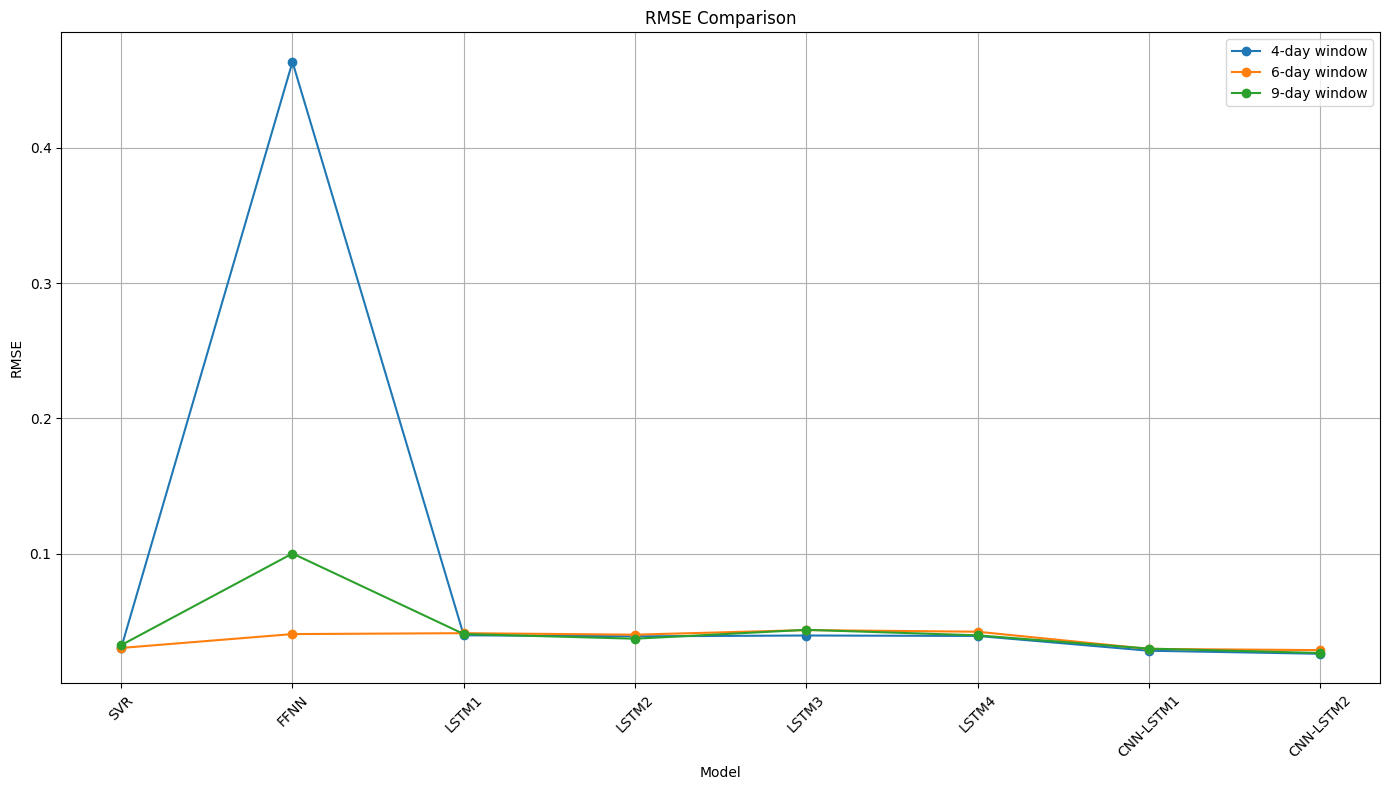

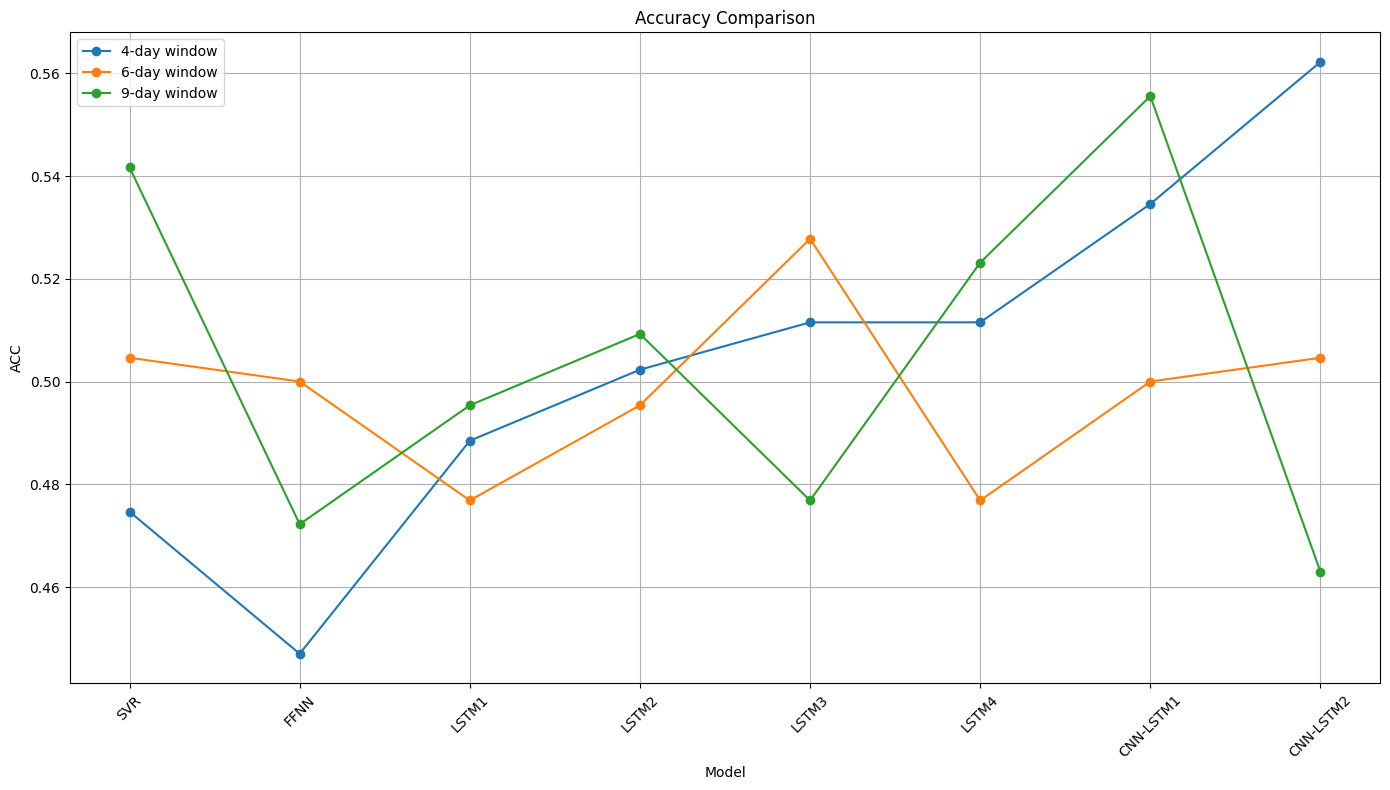

In [5]:
# Plot training histories
for key, history in history_store.items():
    model_name, window_size = key.split('_')
    window_size = int(window_size)
    
    plt.figure(figsize=(12, 4))
    
    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f'{model_name} ({window_size} days) - Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    
    # MAE plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['mean_absolute_error'], label='Train MAE')
    plt.plot(history.history['val_mean_absolute_error'], label='Val MAE')
    plt.title(f'{model_name} ({window_size} days) - MAE')
    plt.ylabel('MAE')
    plt.xlabel('Epoch')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig(f'training_{key}.png')
    plt.close()

# Generate comparison plots
plot_metric_comparison(results_df, 'rmse', 'RMSE Comparison')
plot_metric_comparison(results_df, 'acc', 'Accuracy Comparison')